# ANN vs CNN: MNIST, Fashion-MNIST, CIFAR-10

### importing the necessary libraries

In [1]:
import random
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras import layers
from keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from keras.regularizers import L2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

2025-09-09 12:02:10.115948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757419330.318611      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757419330.371476      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Loading the dataset

In [3]:
def load_dataset(name):
    
    name = name.lower()
    
    if name == "mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = x_train[..., np.newaxis].astype('float32') # adds a new channel (since grayscale image)
        x_test  = x_test[..., np.newaxis].astype('float32') # adds a new channel (since grayscale image)
        class_names = [str(i) for i in range(10)]
        
    elif name == "fashion_mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
        x_train = x_train[..., np.newaxis].astype('float32')
        x_test  = x_test[..., np.newaxis].astype('float32')
        class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                       "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    
    elif name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test  = x_test.astype('float32')
        class_names = ["Airplane","Automobile","Bird","Cat","Deer",
                       "Dog","Frog","Horse","Ship","Truck"]
    
    else:
        raise ValueError("Dataset not supported. Use 'mnist', 'fashion_mnist', or 'cifar10'.")
    
    ## normalizing the pixel values to [0,1]
    x_train /= 255.0
    x_test /= 255.0
    
    ## determining the input shape and the number of class
    input_shape = x_train.shape[1:]
    num_classes = len(np.unique(y_train))
    
    y_train = y_train.reshape(-1,)
    y_test = y_test.reshape(-1,)
    
    return x_train, y_train, x_test, y_test, input_shape, num_classes, class_names

    

### Displaying random images

In [4]:
def show_random_images(x, y, class_names, n = 8, seed = seed):
    np.random.seed(seed)
    
    indices = np.random.choice(len(x), size = n , replace = False)
    
    plt.figure(figsize = (2*n,3))
    for i, idx in enumerate(indices):
        ax = plt.subplot(1,n,i+1)
        img = x[idx]
        ## if the last axis is 1 i.e. grayscale we squeeze the channel dim
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap = 'gray')
        else:
            plt.imshow(img)
        label = class_names[y[idx]]
        plt.title(label)
        plt.axis('off')
    plt.show()

## Building the ANN

In [5]:
def build_ann(input_shape, num_classes, l2 = 1e-4, dropout_rate = 0.5):
    reg = L2(l2)
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    ## Dense layer 1
    model.add(Dense(512, activation=None, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    ## Dense layer 2
    model.add(Dense(256, activation=None, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate*0.5))
    
    ## Output layer 
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer = 'adam', 
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model
    

### Building CNN

In [6]:
def build_cnn(input_shape, num_classes, l2=1e-4, dropout_rate=0.4, use_augmentation=False):
   
    reg = L2(l2)   # L2 regularizer for weight decay

    model = Sequential()

    if use_augmentation:
        ## simple augmentation pipeline (applies only during training)
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1))
        model.add(layers.RandomZoom(0.1))

    ## Conv block 1
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=reg, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate * 0.5))

    ## Conv block 2
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate))

    ## Conv block 3
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate))

    ## Classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(num_classes, activation='softmax'))  # final softmax

    # Compile model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


## Defining callbacks EarlyStopping, ReduceLROnPlateau

In [7]:
def get_callbacks(model_name = 'model', patience_es = 5):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience_es,
                                         restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=max(2, patience_es//2), min_lr=1e-6, verbose=1)
    
    return [early_stop, reduce_lr]

### Training and evaluation

In [8]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test,
                       model_name='model', epochs=300, batch_size=128, patience=5):
    
    ## getting callbacks for this run
    cbs = get_callbacks(model_name=model_name, patience_es=patience)

    ## fitting the model
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=cbs,
                        verbose=1)

    ## evaluating on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

    ## predictions as integer labels
    y_pred_proba = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)            
    
    return history, test_loss, test_acc, y_pred


### Plotting result curves

In [9]:
def plot_history(histories, title_suffix=''):
    
    plt.figure(figsize=(14,5))

    # Accuracy subplot
    plt.subplot(1,2,1)
    for name, hist in histories.items():
        plt.plot(hist.history['accuracy'], label=f'{name} train')
        plt.plot(hist.history['val_accuracy'], '--', label=f'{name} val')
    plt.title('Accuracy ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss subplot
    plt.subplot(1,2,2)
    for name, hist in histories.items():
        plt.plot(hist.history['loss'], label=f'{name} train')
        plt.plot(hist.history['val_loss'], '--', label=f'{name} val')
    plt.title('Loss ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

### Full pipeline

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset: mnist | input_shape: (28, 28, 1) | num_classes: 10
Train samples: 60000 | Test samples: 10000
-- Showing random training images --


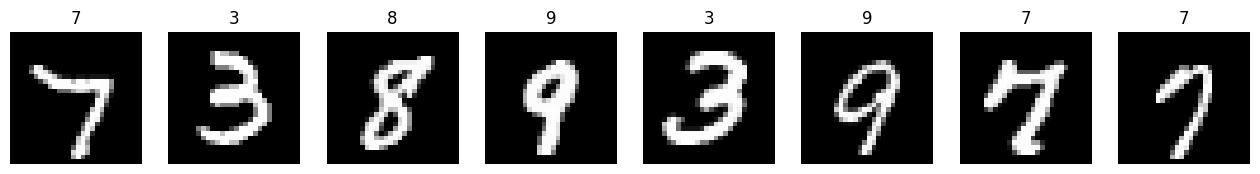


-- Building and training ANN --


I0000 00:00:1757419345.214802      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757419345.215458      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,890 (2.06 MB)

 Trainable params: 537,354 (2.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/300


I0000 00:00:1757419349.796284      61 service.cc:148] XLA service 0x788d8c006650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757419349.796839      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757419349.796864      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757419350.100238      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 65/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6352 - loss: 1.2136

I0000 00:00:1757419352.200858      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8395 - loss: 0.5964 - val_accuracy: 0.9624 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.2478 - val_accuracy: 0.9713 - val_loss: 0.1698 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9581 - loss: 0.2131 - val_accuracy: 0.9726 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9653 - loss: 0.1848 - val_accuracy: 0.9761 - val_loss: 0.1524 - learning_rate: 0.0010
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9690 - loss: 0.1708 - val_accuracy: 0.9767 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.1662 - val_accuracy: 0.9782 - val_loss: 0.1401 - learning_rate: 0.0010
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.1569 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,330 (1.50 MB)

 Trainable params: 391,370 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7621 - loss: 0.8030 - val_accuracy: 0.6009 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9625 - loss: 0.1758 - val_accuracy: 0.9873 - val_loss: 0.0948 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9739 - loss: 0.1389 - val_accuracy: 0.9909 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9791 - loss: 0.1220 - val_accuracy: 0.9917 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9814 - loss: 0.1119 - val_accuracy: 0.9915 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9831 - loss: 0.1070 - val_accuracy: 0.9920 - val_loss: 0.0745 - learning_rate: 0.0010
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9838 - loss: 

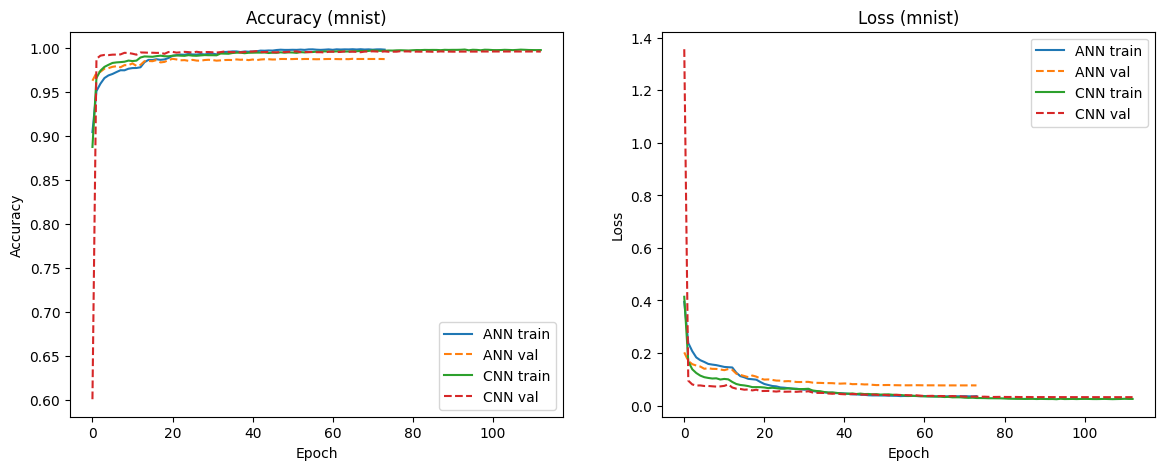


ANN Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.0

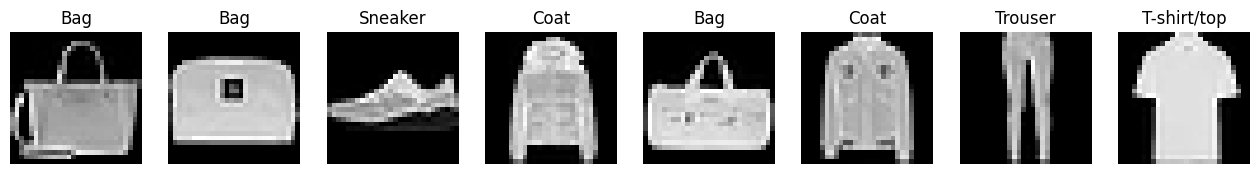


-- Building and training ANN --


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,890 (2.06 MB)

 Trainable params: 537,354 (2.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7564 - loss: 0.7877 - val_accuracy: 0.8521 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8447 - loss: 0.5215 - val_accuracy: 0.8602 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8593 - loss: 0.4765 - val_accuracy: 0.8650 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8653 - loss: 0.4550 - val_accuracy: 0.8722 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8689 - loss: 0.4402 - val_accuracy: 0.8647 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8752 - loss: 0.4271 - val_accuracy: 0.8692 - val_loss: 0.4397 - learning_rate: 0.0010
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8768 - loss: 0.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,330 (1.50 MB)

 Trainable params: 391,370 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.6754 - loss: 0.9765 - val_accuracy: 0.7198 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8356 - loss: 0.5076 - val_accuracy: 0.8719 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8628 - loss: 0.4390 - val_accuracy: 0.8861 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8709 - loss: 0.4093 - val_accuracy: 0.8867 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8812 - loss: 0.3878 - val_accuracy: 0.8980 - val_loss: 0.3424 - learning_rate: 0.0010
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8869 - loss: 0.3743 - val_accuracy: 0.8980 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8904 - loss: 

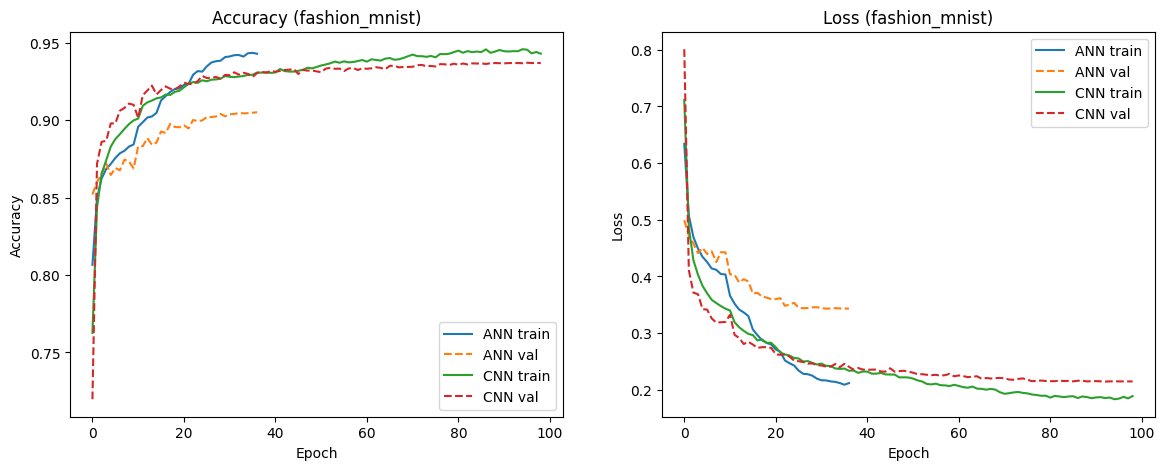


ANN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.83      0.85      0.84      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.85      0.85      0.85      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


CNN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.87      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.9

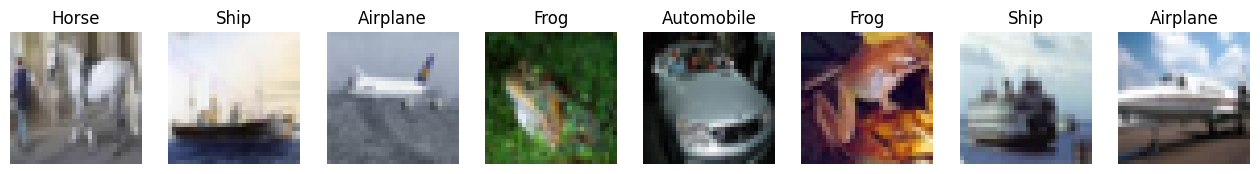


-- Building and training ANN --


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,710,346 (6.52 MB)

 Trainable params: 1,708,810 (6.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3106 - loss: 2.1025 - val_accuracy: 0.2502 - val_loss: 2.1489 - learning_rate: 0.0010
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4122 - loss: 1.7655 - val_accuracy: 0.3093 - val_loss: 2.0471 - learning_rate: 0.0010
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4477 - loss: 1.6735 - val_accuracy: 0.3379 - val_loss: 1.9877 - learning_rate: 0.0010
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4655 - loss: 1.6320 - val_accuracy: 0.3450 - val_loss: 1.9361 - learning_rate: 0.0010
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4736 - loss: 1.6045 - val_accuracy: 0.2942 - val_loss: 2.0717 - learning_rate: 0.0010
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4866 - loss: 1.5796 - val_accuracy: 0.3747 - val_loss: 1.8717 - learning_rate: 0.0010
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4904 - loss: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300


E0000 00:00:1757420295.067959      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_14_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.3103 - loss: 2.0602 - val_accuracy: 0.2601 - val_loss: 2.4160 - learning_rate: 0.0010
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4575 - loss: 1.5552 - val_accuracy: 0.5113 - val_loss: 1.4252 - learning_rate: 0.0010
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5047 - loss: 1.4375 - val_accuracy: 0.5565 - val_loss: 1.2836 - learning_rate: 0.0010
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5372 - loss: 1.3691 - val_accuracy: 0.4666 - val_loss: 1.6248 - learning_rate: 0.0010
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5589 - loss: 1.3139 - val_accuracy: 0.5661 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5781 - loss: 1.2703 - val_accuracy: 0.5442 - val_loss: 1.3560 - learning_rate: 0.0010
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5910 - loss: 1.2354

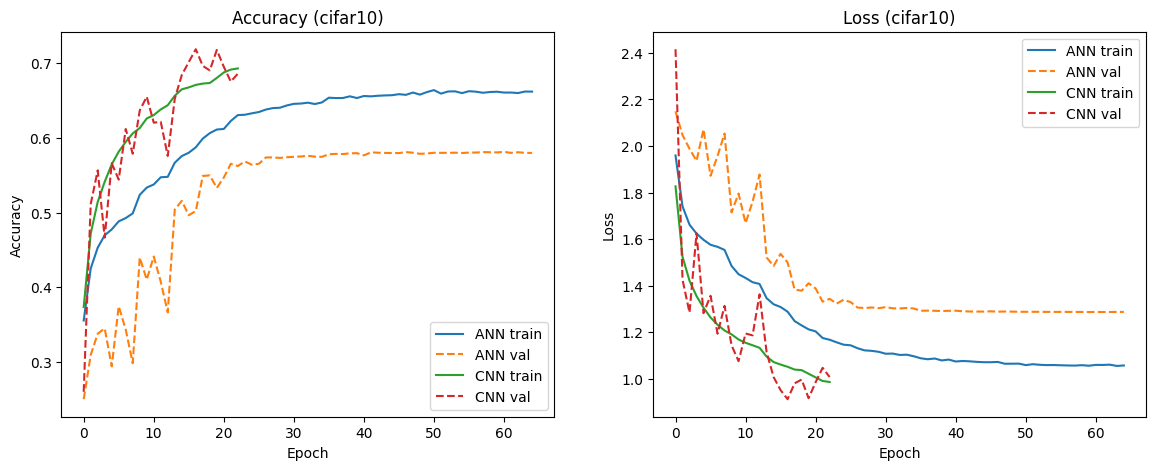


ANN Classification Report:
              precision    recall  f1-score   support

    Airplane       0.65      0.64      0.64      1000
  Automobile       0.69      0.68      0.68      1000
        Bird       0.51      0.41      0.45      1000
         Cat       0.41      0.39      0.40      1000
        Deer       0.53      0.52      0.52      1000
         Dog       0.49      0.47      0.48      1000
        Frog       0.59      0.70      0.64      1000
       Horse       0.63      0.66      0.65      1000
        Ship       0.66      0.71      0.69      1000
       Truck       0.62      0.64      0.63      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000


CNN Classification Report:
              precision    recall  f1-score   support

    Airplane       0.76      0.80      0.78      1000
  Automobile       0.86      0.89      0.87      1000
        Bird       0.7

In [10]:
def run_experiment(dataset_name, epochs_ann=300, epochs_cnn=300, batch_size=128):
    
    ## 1) Loading dataset
    x_train, y_train, x_test, y_test, input_shape, num_classes, class_names = load_dataset(dataset_name)
    print(f"Dataset: {dataset_name} | input_shape: {input_shape} | num_classes: {num_classes}")
    print(f"Train samples: {len(x_train)} | Test samples: {len(x_test)}")

    ## 2) Showing random samples
    print("-- Showing random training images --")
    show_random_images(x_train, y_train, class_names, n=8)

    # 3) Building and training ANN
    print("\n-- Building and training ANN --")
    ann = build_ann(input_shape, num_classes, l2=1e-4, dropout_rate=0.5)
    ann.summary()
    ann_history, ann_loss, ann_acc, ann_pred = train_and_evaluate(ann, x_train, y_train,
                                                                  x_test, y_test,
                                                                  model_name=f"{dataset_name}_ann",
                                                                  epochs=epochs_ann,
                                                                  batch_size=batch_size,
                                                                  patience=5)
    print(f"ANN Test loss: {ann_loss:.4f} | ANN Test accuracy: {ann_acc:.4f}")

    # 4) Building and training CNN
    print("\n-- Building and training CNN --")
    # use augmentation for CIFAR-10 dataset
    use_aug = True if dataset_name == 'cifar10' else False
    cnn = build_cnn(input_shape, num_classes, l2=1e-4, dropout_rate=0.4, use_augmentation=use_aug)
    cnn.summary()
    cnn_history, cnn_loss, cnn_acc, cnn_pred = train_and_evaluate(cnn, x_train, y_train,
                                                                  x_test, y_test,
                                                                  model_name=f"{dataset_name}_cnn",
                                                                  epochs=epochs_cnn,
                                                                  batch_size=batch_size,
                                                                  patience=6)
    print(f"CNN Test loss: {cnn_loss:.4f} | CNN Test accuracy: {cnn_acc:.4f}")

    ## 5) Plotting training histories together for comparison
    plot_history({'ANN': ann_history, 'CNN': cnn_history}, title_suffix=f'({dataset_name})')

    ## 6) Classification reports
    print("\nANN Classification Report:")
    print(classification_report(y_test, ann_pred, target_names=class_names))

    print("\nCNN Classification Report:")
    print(classification_report(y_test, cnn_pred, target_names=class_names))

    ## 7) Returning useful outputs
    return {
        'ann_model': ann,
        'cnn_model': cnn,
        'ann_history': ann_history,
        'cnn_history': cnn_history,
        'ann_acc': ann_acc,
        'cnn_acc': cnn_acc,
        'ann_pred': ann_pred,
        'cnn_pred': cnn_pred,
        'y_test': y_test,
        'class_names': class_names
    }


results_mnist  = run_experiment('mnist', epochs_ann=300, epochs_cnn=300, batch_size=128)
results_fash   = run_experiment('fashion_mnist', epochs_ann=300, epochs_cnn=300, batch_size=128)
results_cifar  = run_experiment('cifar10', epochs_ann=300, epochs_cnn=300, batch_size=128)

print("\n=== Summary of test accuracies ===")
print(f"MNIST  => ANN: {results_mnist['ann_acc']:.4f} | CNN: {results_mnist['cnn_acc']:.4f}")
print(f"FASH   => ANN: {results_fash['ann_acc']:.4f} | CNN: {results_fash['cnn_acc']:.4f}")
print(f"CIFAR  => ANN: {results_cifar['ann_acc']:.4f} | CNN: {results_cifar['cnn_acc']:.4f}")


C:\Users\TUFAN\AppData\Local\Temp\ipykernel_4104\106372196.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=subset, palette="viridis")


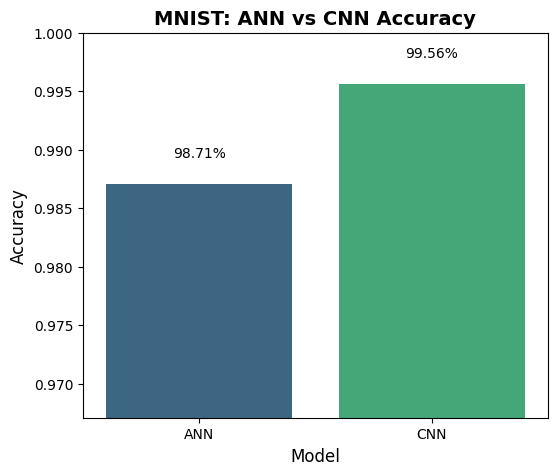

C:\Users\TUFAN\AppData\Local\Temp\ipykernel_4104\106372196.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=subset, palette="viridis")


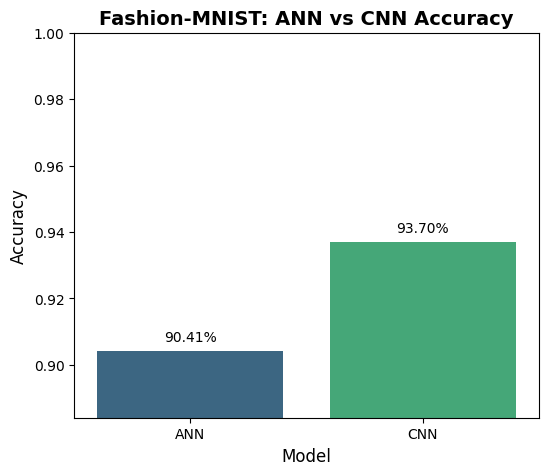

C:\Users\TUFAN\AppData\Local\Temp\ipykernel_4104\106372196.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=subset, palette="viridis")


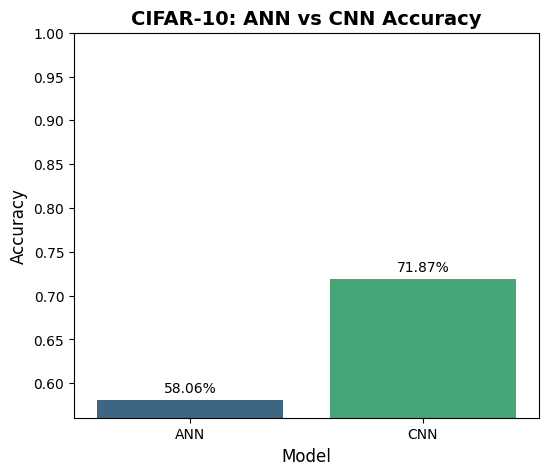

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Accuracy data
data = {
    "Dataset": ["MNIST", "MNIST", "Fashion-MNIST", "Fashion-MNIST", "CIFAR-10", "CIFAR-10"],
    "Model": ["ANN", "CNN", "ANN", "CNN", "ANN", "CNN"],
    "Accuracy": [0.9871, 0.9956, 0.9041, 0.9370, 0.5806, 0.7187]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot separate graphs for each dataset
datasets = df["Dataset"].unique()

for dataset in datasets:
    plt.figure(figsize=(6, 5))  
    subset = df[df["Dataset"] == dataset]  
    sns.barplot(x="Model", y="Accuracy", data=subset, palette="viridis")  
    plt.ylim(subset["Accuracy"].min() - 0.02, 1.0) 
    
    # Add accuracy labels on top of each bar
    for i, v in enumerate(subset["Accuracy"]):
        offset = 0.005 if v < 0.9 else 0.002
        plt.text(i, v + offset, f"{v*100:.2f}%", ha="center", va="bottom", fontsize=10)
    
    plt.title(f"{dataset}: ANN vs CNN Accuracy", fontsize=14, weight="bold")
    plt.ylabel("Accuracy", fontsize=12)  
    plt.xlabel("Model", fontsize=12)  
    plt.show() 